<a id="Top"></a>
# **Machine Learning Model to predict Band Gaps and Urbach Tail of Distorted Photoelectronic Structures**

All data used are structural poscar files, calculated using DFT. In addition band gaps and absorption spectra are used to train the model.


## Loading of Libraries and Directories
For adjusting Working Directory of POSCAR Structure Files, loading common libraries

In [1]:
#Adjust The directory before anything
working_directory = 
poscar_directory_path = 
features_directory=
spectra_directory =

import os
import re
import ast
import json
import glob
import numpy as np
import pandas as pd
from pymatgen.io.vasp import Poscar
from matminer.utils.io import load_dataframe_from_json
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

### File Labels
Creating a df for column names for each Structure, as 'df_label'

In [ ]:
# Pattern to match all POSCAR files
file_pattern = os.path.join(poscar_directory_path, "POSCAR_*")

# Initialize an empty list to store the POSCAR labels
poscar_labels = []

# Iterate over each file that matches the pattern, sorted to ensure numerical order
for i, filepath in enumerate(sorted(glob.glob(file_pattern)), start=1):
    # Generate a label for each POSCAR file
    label = f"POSCAR_{i}"
    # Append the label to the list
    poscar_labels.append(label)

# Convert the list to a DataFrame
df_label = pd.DataFrame(poscar_labels, columns=['POSCAR_*'])

# Checking
print(df_label.head(2))

### BandGap
Loading Actual BandGap Data into Dataframe

This code is different as the data value is in a sentence, hence to extract it, is harder

In [ ]:
import re

# Path to your directory containing bandgap files
file_path = os.path.join(working_directory,"extracted_bandgaps/")

# Pattern to match all bandgap_* files
file_pattern = os.path.join(file_path, "bandgap_*")

# Initialize an empty list to store the bandgap values
bandgap_values = []

# Extract only numerical value from text file
x = r"band gap =\s*([\d.]+)"

# Iterate over each file that matches the pattern
for filepath in glob.glob(file_pattern):
    # Open and read the content of the current bandgap files
    with open(filepath, 'r') as file:
        content = file.read()
        
        # Search for the bandgap value using the expression
        match = re.search(x, content)
        if match:
            # Extract the numerical value as a float
            bandgap_value = float(match.group(1))
            
            # Append the bandgap value to the list
            bandgap_values.append(bandgap_value)

# Convert List to Df
gap = pd.DataFrame(bandgap_values, columns=['Bandgap/eV'])

output_path = os.path.join(features_directory, "all_bandgap.csv")
gap.to_csv(output_path, index=False)
print(gap.head(2))

#Combining the label and bandgap
df_target = pd.concat([df_label, gap], axis=1)
df_target = pd.DataFrame(df_target)

output_path = os.path.join(features_directory, "label_and_bandgap.csv")
df_target.to_csv(output_path, index=False)
# For checking
print(df_target.head(2))



<a id="JarvisCFID"></a>
### Jarvis CFID Descriptor

Jarvis CFID feature, use_chg= False, use_chem=False, use_cell=False, these values are the constant, 
use=rdf = False (will use another featurizer separately for radial distribution)

In [ ]:
from matminer.featurizers.structure.composite import JarvisCFID
jarvis_cfid= JarvisCFID(use_cell=False, use_chem=False, use_chg=False, use_rdf=False, use_adf=True, use_ddf=True, use_nn=True)

# Get the feature labels
feature_labels = jarvis_cfid.feature_labels()

#temp storage
data = []

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Load each POSCAR file, convert to Structure, and featurize
for poscar_path in poscar_files:
    poscar = Poscar.from_file(poscar_path) 
    s = poscar.structure
    CFID_feature = jarvis_cfid.featurize(s)
    data.append(CFID_feature)

cfid_df = pd.DataFrame(data, columns=feature_labels)

output_path = os.path.join(features_directory, "jcfid.csv")
cfid_df.to_csv(output_path, index=False)


<a id="AFS"></a>
### Angular Fourier Series Descriptor
(Doesnt work yet?)
Angular Fourier Series: The AFS is the product of pairwise distance function (g_n, g_n’) between two pairs of atoms (sharing the common central site) and the cosine of the angle between the two pairs

In [ ]:
from matminer.featurizers.site.rdf import AngularFourierSeries

afs= AngularFourierSeries.from_preset('gaussian')

# Get the feature labels
feature_labels = afs.feature_labels()
data = []
# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Load each POSCAR file, convert to Structure, and featurize
for poscar_path in poscar_files:
    poscar = Poscar.from_file(poscar_path)
    s = poscar.structure
    afs_feature = afs.featurize(s,1)
    data.append(afs_feature)

afs_df = pd.DataFrame(data, columns=feature_labels)
print(afs_df.head())

output_path = os.path.join(features_directory, "afs_feature.csv")
afs_df.to_csv(output_path, index=False)

<a id="OFM"></a>
### Orbital Field Matrix Descriptor
(Does Not work)
Orbital Field Matrix. Takes too long to generate features. [8 Sec per Struct, seems like all value are 0]

In [ ]:
from matminer.featurizers.structure.matrix import OrbitalFieldMatrix

ofm = OrbitalFieldMatrix(period_tag=True, flatten=True)

#Featurizing to get the average OFM of a structure
#mean_ofm = ofm.featurize()

data =[]
# Get the feature labels
feature_labels = ofm.feature_labels()

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Load each POSCAR file, convert to Structure, and featurize
for poscar_path in poscar_files:
    poscar = Poscar.from_file(poscar_path)
    s = poscar.structure
    ofm_feature = ofm.featurize(s)
    data.append(ofm_feature)
    #Featurizing to get the average OFM of a structure
    #mean_ofm = ofm.featurize(s)
    
ofm_df = pd.DataFrame(data, columns=feature_labels)
print(ofm_df.head())
output_path = os.path.join(features_directory, "ofm.csv")
ofm_df.to_csv(output_path, index=False)

<a id="RDF"></a>
### Radial Distribution Descriptor

RadialDistributionFunction Feature (RDF), saved as rdf_df

In [ ]:
from matminer.featurizers.structure.rdf import RadialDistributionFunction

rdf = RadialDistributionFunction()

# Get the feature labels
feature_labels = rdf.feature_labels()
data = []

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Load each POSCAR file, convert to Structure, and featurize
for poscar_path in poscar_files:
    poscar = Poscar.from_file(poscar_path)
    s=poscar.structure
    rdf_feat= rdf.featurize(s)
    data.append(rdf_feat)

#appending the col labels to its features
rdf_df = pd.DataFrame(data, columns=feature_labels)
print(rdf_df.head())

output_path = os.path.join(features_directory, "rdf.csv")
rdf_df.to_csv(output_path, index=False)

<a id="XRD"></a>
### Powder Pattern Descriptor

XRD Powder Pattern Feature , Spectra, saved as xrd_df

In [ ]:
from matminer.featurizers.structure.misc import XRDPowderPattern

xrd = XRDPowderPattern()
feature_labels = xrd.feature_labels()

#temp storage
data = []

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Load each POSCAR file, convert to Structure, and featurize
for poscar_path in poscar_files:
    poscar = Poscar.from_file(poscar_path)
    s=poscar.structure
    xrd_featurize= xrd.featurize(s)
    data.append(xrd_featurize)

#appending the col labels to its features
xrd_df=pd.DataFrame(data, columns=feature_labels)

#Save xrd_df to Excel
output_path = os.path.join(features_directory, "Xrd_features.csv")
xrd_df.to_csv(output_path, index=False)
            

<a id="mrd"></a>
### Minimum Relative Distance Descriptor

MinimumRelativeDistance (MRD) feature, saving these features into 'MRD_dataframe'
Takes too long to generate Features

In [ ]:
from matminer.featurizers.structure.bonding import MinimumRelativeDistances

MRD = MinimumRelativeDistances(flatten= True)
#Creating empty temporary dataframe
temp_df = pd.DataFrame(columns=['Min-distance'])

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Load each POSCAR file, convert to Structure, and featurize
for poscar_path in poscar_files:
    poscar = Poscar.from_file(poscar_path)
    #structurize the poscar file
    s = poscar.structure
    MRD.fit([s])
    MRD_feat = MRD.featurize(s)
    #Extracting on the numerical value for usage
    numerical_values = [x for x in MRD_feat if isinstance(x, float)]
    #Saving the values in rows, with labels according to the number of minimumdistance between each atom
    temp_df_row = pd.DataFrame([numerical_values], columns=[f"Min-distance ({i})" for i in range(len(numerical_values))])
    temp_df = pd.concat([temp_df, temp_df_row], ignore_index=True)
    
#removing NA values.
MRD_dataframe = temp_df.dropna(axis=1, how='all')
print(MRD_dataframe)

output_path = os.path.join(features_directory, "mrd_feature.csv")
mrd_df.to_csv(output_path, index=False)

### Sine Coulomb Matrix Featurizer Steps
#### Sine Coulomb Matrix Step (1)

Sine Coulomb Matrix Feature saved into a Dataframe called 'sine_dataframe', Storing it in h5 file as it is too large for Excel

In [ ]:
from matminer.featurizers.structure.matrix import SineCoulombMatrix
import h5py  # Import h5py for working with HDF5 format

# Output HDF5 file path
hdf5_file_path = os.path.join(features_directory, 'sine_coulomb_features.h5')

# Initialize the SineCoulombMatrix featurizer with flatten=False to get the matrix form
sine_featurizer = SineCoulombMatrix(flatten=False)

# Open or create the HDF5 file
with h5py.File(hdf5_file_path, 'w') as hdf5_file:
    # List all POSCAR files using glob.glob and sort them in numerical order
    poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

    # Load each POSCAR file, convert to Structure, and featurize
    for poscar_path in poscar_files:
        # Extract the structure number from the filename for use in the dataset name
        structure_num = os.path.basename(poscar_path).split('_')[1]

        poscar = Poscar.from_file(poscar_path)
        s = poscar.structure
        
        # Featurize the structure, into sine_matrix. Alteration can be done on this sine_matrix
        sine_matrix = sine_featurizer.featurize(s)[0]
        
        # Flatten the sine matrix
        flattened_matrix = sine_matrix.flatten()
        
        # Store the flattened matrix in the HDF5 file
        hdf5_file.create_dataset(f'structure_{structure_num}', data=flattened_matrix)

print(f"Featurization complete, data stored in HDF5 format: {hdf5_file_path}")


#### Sine Coulomb Matrix Step (2A - Finding Eigenvalue , Skip to next feature)
Eigenvalue of Sine_matrix to reduce dimensionality of matrix

In [ ]:
# Initialize the SineCoulombMatrix featurizer with flatten=False to get the matrix form
sine_featurizer = SineCoulombMatrix(flatten=False)

# Initialize a list to collect all eigenvalues, each set of eigenvalues will be a list
all_eigenvalues = []

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Load each POSCAR file, convert to Structure, and featurize
for poscar_path in poscar_files:
    # Extract the structure number from the filename for use in the dataset name
    structure_num = os.path.basename(poscar_path).split('_')[1]

    poscar = Poscar.from_file(poscar_path)
    s = poscar.structure
    
    # Featurize the structure into sine_matrix
    sine_matrix_df = sine_featurizer.featurize(s)[0]
    
    # Convert the DataFrame to a numpy array if sine_matrix is a DataFrame
    sine_matrix = sine_matrix_df.values if isinstance(sine_matrix_df, pd.DataFrame) else sine_matrix_df

    # Compute eigenvalues of the sine matrix
    eigenvalues = np.linalg.eigvals(sine_matrix)
    
    # Since eigenvalues might be complex, take their absolute values if necessary
    abs_eigenvalues = np.abs(eigenvalues)

    # Append the eigenvalues (as a list) to our collection
    all_eigenvalues.append(abs_eigenvalues)

#In case number of Eigenvalues differ from structure to structure
# Find the maximum number of eigenvalues in any set
max_columns = max(len(eig) for eig in all_eigenvalues)

# Generate column names based on the maximum number found
column_names = [f'E_{i+1}' for i in range(max_columns)]

# Create a DataFrame, allowing shorter lists to have NA for missing values
eigenvalues_sine_df = pd.DataFrame(all_eigenvalues, columns=column_names)

# Save the DataFrame to an Excel file
eigenvalues_sine_df.to_csv(os.path.join(features_directory,'eigenvalue_SCM.csv'), index=False)

#### Sine Coulomb Matrix Step (2B - Removing Diagonals)
Data adjustment complete and original HDF5 file overwritten (No need this, unless not using Eigenvalues of SineMatrix)

In [ ]:
# Define the HDF5 file path for both reading and writing
hdf5_file_path = os.path.join(features_directory, "sine_coulomb_features.h5")

def remove_diagonals_from_flattened(flattened_matrix, matrix_size):
    square_matrix = flattened_matrix.reshape(matrix_size, matrix_size)
    np.fill_diagonal(square_matrix, np.nan)
    return square_matrix[~np.isnan(square_matrix)]

# Temporary storage for adjusted data
temp_data = {}

# First pass: Read from the HDF5 file and process the data
with h5py.File(hdf5_file_path, 'r') as hdf5_file:
    for structure_name in hdf5_file:
        structure_data = hdf5_file[structure_name][:]
        matrix_size = int(np.sqrt(structure_data.size))
        no_diagonals = remove_diagonals_from_flattened(structure_data, matrix_size)
        temp_data[structure_name] = no_diagonals

# Second pass: Overwrite the HDF5 file with the adjusted data
with h5py.File(hdf5_file_path, 'w') as hdf5_file:
    for structure_name, no_diagonals in temp_data.items():
        hdf5_file.create_dataset(structure_name, data=no_diagonals)

print("Data adjustment complete and original HDF5 file overwritten.")



### Density Feature Descriptor

Density feature to obtain: ' Density, Vol Per Atom, Packing fract' and saving this Dataframe into density_dataframe

In [ ]:
from matminer.featurizers.structure import DensityFeatures
df_feat = DensityFeatures()
#df_feat.feature_labels() # 3 Values of these labels
#['density', 'volume per atom, vpa', 'packing fraction']
density_names = df_feat.feature_labels()

density_list=[]

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Load each POSCAR file, convert to Structure, and featurize
for poscar_path in poscar_files:
    poscar = Poscar.from_file(poscar_path)
    s=poscar.structure
    df= df_feat.featurize(s)
    
    #Adding labels to the feature data
    density = dict(zip(density_names, df))
    
    #Saving Density Feature (densityf_list)
    density_list.append(density)
    
#Saving it into Excel
density_dataframe = pd.DataFrame(density_list)
output_path = os.path.join(features_directory, 'density_features.csv')
density_dataframe.to_csv(output_path,index = False)
print(density_dataframe.head())


<a id="ewald"></a>
### Ewald Sum Matrix Descriptor

EwaldSumMatrix Feature, saved as ESM_Summation.csv .
Adjust "n_atoms_max" to the no. atoms in the structure

In [ ]:
from dscribe.descriptors import EwaldSumMatrix
from ase.io import read

# Initialize descriptors
esm = EwaldSumMatrix(n_atoms_max=192) 
#Empty atoms will be filled with zeros, 96 Gallium 96 Nitrite. adjust accordingly if required

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Initialize a list to store sums of values above the diagonal for each matrix
data = []

# Load each POSCAR file, convert to Pymatgen Structure to Atomic Positioning and then Ewald sum matrix
for poscar_path in poscar_files:
    # Read the structure using ASE
    s = read(poscar_path)

    # Create the Ewald sum matrix
    ewald_matrix = esm.create(s)
    ewald_matrix = esm.unflatten(ewald_matrix)

    # Calculate the sum of elements above the diagonal, including the diagonal
    sum_above_diagonal = np.sum(np.triu(ewald_matrix, k=0))
    
    # Append the file name and sum to the data list
    data.append({
        "ESM": sum_above_diagonal
    })

# Create DataFrame from the collected data
esm_df = pd.DataFrame(data)

# Save the DataFrame to CSV
esm_df.to_csv(os.path.join(features_directory, 'ESM_Summation.csv'), index=False)

<a id="soap"></a>
### SOAP Descriptor

Smooth Overlap of Atomic Positions (SOAP) descriptor

In [ ]:
from ase.io import read
from dscribe.descriptors import SOAP

species = ["Ga", "N"] #Listing all elements
r_cut = 2 # cutoff for local region in angstroms. Should be bigger than 1 angstrom for the gto-basis
n_max = 1 # The number of radial basis functions
l_max = 1 # The maximum degree of spherical harmonics.

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,  # Set to True if you want the descriptor output to respect the periodicity of the atomic systems
    average = 'inner',
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
)

# List all POSCAR files using glob.glob and sort them in numerical order
poscar_files = sorted(glob.glob(os.path.join(poscar_directory_path, "POSCAR_*")), key=lambda x: int(os.path.basename(x).split('_')[1]))

# Initialize a list to store sums of values above the diagonal for each matrix
data = []

# Load each POSCAR file, convert to Pymatgen Structure to Atomic Positioning and then Ewald sum matrix
for poscar_path in poscar_files:
    # Read the structure using ASE
    s = read(poscar_path)
    
    f = soap.create(s)
    
    label = {}
    for i, value in enumerate(f):  #Generate Labels for SOAP Descriptor
        label[f'Soap_{i+1}'] = value
    
    # Append the descriptors and the filename to the data list
    data.append(label)

# Convert list to DataFrame
soap_df = pd.DataFrame(data)

# Saving the DataFrame to a CSV file
soap_df.to_csv(os.path.join(features_directory, 'SOAP_Descriptors.csv'), index=False)

print("All SOAP descriptors have been calculated and saved.")


<a id="Feature-Collation"></a>
### Feature Collation

Collating the DataFrames and saving onto Excel as <strong> 'combined_features.csv' </strong>

In [ ]:
#Combining DF along its rows, assuming all DF has same number of rows
#Take note, Density features not included

dataframes = [df_target, eigenvalues_sine_df, cfid_df, rdf_df, xrd_df, esm_df, soap_df]

#Realign if eigenvalue_df indexes are not aligned
aligned_dfs = [df.reset_index(drop=True) for df in dataframes]
features_df = pd.concat(aligned_dfs, axis=1)

# Define the path where you want to save the excel file
output_path = os.path.join(features_directory,'combined_features.csv')

# Save the combined DataFrame 
features_df.to_csv(output_path,index=True)

print(features_df.head(2))

<a id="Individual-Feature-Loading"></a>
## Feature Loading

##### Individual features
Loading Individual Dataframe from file (Faster, if features already generated)

In [2]:
#Loading individual Features from their respective Excel.
#Run * if loading sinecoulombmatrix 's h5 file see next line

df_target = pd.read_csv(os.path.join(features_directory,'label_and_bandgap.csv'),index_col=0)
print('df_target colummn:', len(df_target.columns)) #2

#density_dataframe = pd.read_csv(os.path.join(features_directory,'density_features.csv'),index_col=0)
#print('density colummn:' len(density_dataframe.columns)) #3

cfid_df = pd.read_csv(os.path.join(features_directory,'jcfid.csv'),index_col=0)
print('Jarvis cfid_df colummn:', len(cfid_df.columns))
#adf1 (179), adf2 (179), ddf (179), nn (100)

xrd_df = pd.read_csv(os.path.join(features_directory,'Xrd_features.csv'),index_col=0)
print('XRD Powder Pattern colummn:', len(xrd_df.columns)) #128

rdf_df = pd.read_csv(os.path.join(features_directory,'rdf.csv'),index_col=0)
print('Radial Distribution colummn:', len(rdf_df.columns)) #200

eigenvalues_sine_df = pd.read_csv(os.path.join(features_directory,'eigenvalue_SCM.csv'),index_col=0)
print('SCM Eigenvalues colummn:', len(eigenvalues_sine_df.columns)) #192

esm_df = pd.read_csv(os.path.join(features_directory,'ESM_Summation.csv'),index_col=0)
print('Ewald Sum Matrix colummn:', len(esm_df.columns)) #1

soap_df= pd.read_csv(os.path.join(features_directory,'SOAP_Descriptors.csv'),index_col=0)
print('SOAP_Descriptor colummn:', len(soap_df.columns)) #6

#No. Columns will be useful when splicing for cross-validation to see features' "Importance"

#would need to write in the additional features that may have been left out

df_target colummn: 1
Jarvis cfid_df colummn: 636
XRD Powder Pattern colummn: 127
Radial Distribution colummn: 199
SCM Eigenvalues colummn: 191
Ewald Sum Matrix colummn: 0
SOAP_Descriptor colummn: 5


##### Preloading SinecoulumbMatrix if required
*Loading the HDF5 data back onto a Dataframe, "Sine_dataframe" (Continuation of previous code, not needed unless Eigenvalues are not used)

In [ ]:
# Specify the HDF5 file path
hdf5_file_path = os.path.join(features_directory, "sine_coulomb_features.h5")

# Initialize a list to hold the data
data = []

# Open the HDF5 file in read mode
with h5py.File(hdf5_file_path, 'r') as hdf5_file:
    # Iterate through each dataset in the file
    for structure_name in hdf5_file:
        # Read the data for the current structure
        structure_data = hdf5_file[structure_name][:]
        
        # Append the flattened matrix (or processed data) to the data list
        data.append(structure_data)

# Convert the list of data into a DataFrame
# Here, each row represents a structure, and each column represents a feature
sine_dataframe = pd.DataFrame(data)

#Name the columns
num_features = sine_dataframe.shape[1]  # Number of features in your dataset
sine_dataframe.columns = [f'SCM_{i}' for i in range(1, num_features + 1)]

# Now you have a DataFrame containing the data extracted from the HDF5 file
print(sine_dataframe.tail())


##### Preloading Combined Feature
Loading Overall Combined Feature Dataframe from file (Faster, if features already generated)

In [4]:
# Define the path to your featurize parameters file
output_path = os.path.join(features_directory,'combined_features.csv')

# Load the DataFrame from the excel file
features_df = pd.read_csv(output_path,index_col=0)

#Now, `features_df` contains the DataFrame loaded from the excel file
print(features_df.tail(1))
print(features_df.iloc[:, 0])

       POSCAR_*  Bandgap/eV          E_1          E_2          E_3  \
637  POSCAR_638    1.515942  6558.453712  2857.792101  2846.674638   

             E_4         E_5          E_6          E_7          E_8  ...  \
637  2392.385447  2390.50386  2381.183621  2385.494818  2174.469444  ...   

      xrd_125   xrd_126   xrd_127           ESM    Soap_1    Soap_2    Soap_3  \
637  0.000269  0.000032  0.000002 -51976.528636  4.749437  0.000008  4.749144   

       Soap_4    Soap_5    Soap_6  
637 -0.000008  4.748851  0.000008  

[1 rows x 1166 columns]
0        POSCAR_1
1        POSCAR_2
2        POSCAR_3
3        POSCAR_4
4        POSCAR_5
          ...    
633    POSCAR_634
634    POSCAR_635
635    POSCAR_636
636    POSCAR_637
637    POSCAR_638
Name: POSCAR_*, Length: 638, dtype: object


##### Optional step
This step is **[Optional]** as lower band gaps have higher discrepancies

Removing the lowest 50 Band gap values, It overwrites so do not run this multiple times , else reload the feature_df.

In [ ]:
# Sort the DataFrame by 'Bandgap/eV' in ascending order
gap_sorted = features_df.sort_values(by='Bandgap/eV')

# Drop the first 50 rows
features_df = gap_sorted.iloc[50:]

# Reset the index for the new DataFrame and drop the old index
features_df.reset_index(drop=True, inplace=True)

# Now 'gap_filtered' is your DataFrame without the 50 lowest bandgap values
print(features_df.head())

## Modelling to predict Band Gap

Using the features generated above as predictors to predict the band gap
#### Train Test Data Set Split
80-20 split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#selecting training variable (X) and test variable (y)
X = features_df.iloc[:,2:] # Starting from 2nd column which is after Band gap
y = features_df['Bandgap/eV'] #Value to predict

print(X.head(1)) #Check if X is correct

#Splitting dataset into training and testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

### Training Model without hypertuning
Training Model using SciKit Learn on Dataframe 'features_df', without tuning. (can be skipped)

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Training Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=100)
rf_model.fit(X_train, y_train)

#Test error
y_pred_test = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Default Test Set:", rmse, 'eV')
r2_test = r2_score(y_test, y_pred_test)
print("Test R² Score: {:.5f}".format(r2_test))

#Training error
y_pred_train = rf_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Default Train Set:", rmse, 'eV')
r2_train = r2_score(y_train, y_pred_train)
print("Training R² Score: {:.5f}".format(r2_train))


Root Mean Squared Error on Default Test Set: 0.0391540550450819 eV
Test R² Score: 0.42068
Root Mean Squared Error on Default Train Set: 0.016712434507854534 eV
Training R² Score: 0.90376


#### Training on whole data set
Saving predicted bandgap as "predicted_bandgap.csv"

In [10]:
# Using the trained model to predict on the entire dataset
y_pred_all = rf_model.predict(X)

predicted_df = pd.DataFrame()
# Adding predictions as a new column to the original DataFrame
predicted_df['Predicted_bandgap'] = y_pred_all

output_path = os.path.join(features_directory, "predicted_bandgap.csv")
predicted_df.to_csv(output_path,index = True)
print(predicted_df.head())

   Predicted_bandgap
0           1.517824
1           1.521106
2           1.520189
3           1.515983
4           1.501591


#### Visualisation of model without hypertuning
Plotting of Model without Tuning

In [ ]:
# Plot actual vs predicted values for Test Set
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.3)

# Diagonal Line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red') 

# Plot Labels
plt.title('Actual vs Predicted Bandgap (Test)')
plt.xlabel('Actual Bandgap/eV')
plt.ylabel('Predicted Bandgap/eV')
plt.grid(True)
plt.show()

# Plot actual vs predicted values for Train Set
plt.figure(figsize=(10, 8))
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.3)

# Diagonal Line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red') 

# Plot Labels
plt.title('Actual vs Predicted Bandgap (Train)')
plt.xlabel('Actual Bandgap/eV')
plt.ylabel('Predicted Bandgap/eV')
plt.grid(True)
plt.show()

### Selective Feature Modelling 
function SelectFromModel is used to selectively take important features as predictors

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Training Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=100)
rf_model.fit(X_train, y_train)

#Custom threshold
importances = rf_model.feature_importances_
custom_threshold = np.percentile(importances, 75)  # Use the top 25% of parameter

# Use SelectFromModel to select features based on importance
selector = SelectFromModel(rf_model, prefit=True, threshold='mean')

# Transform X to the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)



#### Checking Selected Features
Checking the Selected and Not Selected Features

In [ ]:
selected_features_mask = selector.get_support()
# Inverting the boolean mask to filter out the non-selected features
not_selected_features_mask = ~selector.get_support()

selected_columns = X.columns[selected_features_mask]
not_selected_columns = X.columns[not_selected_features_mask]

print("Selected features:", selected_columns)
print("Non-selected features:", not_selected_columns)


#### Retraining of model with Selective features
With the Selected set of features, retrain the model

In [ ]:
#Retraining the model with selected parameters
rf_model_selected = RandomForestRegressor(n_estimators=100, random_state=100)
rf_model_selected.fit(X_train_selected, y_train)

# Predict and evaluate the model for Test_selected Set
y_pred_test_selected = rf_model_selected.predict(X_test_selected)

# Predict and evaluate the model for Training_selected Set
y_pred_train_selected = rf_model_selected.predict(X_train_selected)


#### Re-Predicting of Bandgap with Selective Features

This overwrites previously saved predicted bandgaps

In [ ]:
# Using the trained model to predict on the entire dataset
y_pred_all = rf_model_selected.predict(X)

predicted_df = pd.DataFrame()
# Adding predictions as a new column to the original DataFrame
predicted_df['Predicted_bandgap'] = y_pred_all

output_path = os.path.join(features_directory, "predicted_bandgap.csv")
predicted_df.to_csv(output_path,index = True)
print(predicted_df.head(3))

#### Performance of Selected RF Model

In [ ]:
#Test error
mse = mean_squared_error(y_test,y_pred_test_selected)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Default Test Set:{:.5f}", rmse, 'eV')
r2_test = r2_score(y_test, y_pred_test_selected)
print("Test R² Score: {:.5f}".format(r2_test))

#Training error
mse = mean_squared_error(y_train, y_pred_train_selected)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Default Train Set:{:.5f}", rmse, 'eV')
r2_train = r2_score(y_train, y_pred_train_selected)
print("Training R² Score: {:.5f}".format(r2_train))


#### Visualization of Selected Model Performance

In [ ]:
import matplotlib

# Plot actual vs predicted values for Training Set (SELECTED PARAMETERS)
plt.figure(figsize=(10, 8))
plt.scatter(y_train, y_pred_train_selected, color='blue', alpha=0.3)

# Diagonal Line
plt.plot([min(y_train), max(y_pred_train_selected)], [min(y_train), max(y_pred_train_selected)], linestyle='--', color='red')

# Plot Labels
plt.title('Actual vs Predicted Bandgap for Selected Model')
plt.xlabel('Actual Bandgap/eV')
plt.ylabel('Predicted Bandgap/eV')
plt.grid(True)
plt.show()


## Hypertuning Options + final visualization

Follow each step accordingly either the A route or B route for hypertuning. 

#### Option (A.1) 
Model hypertuning Option (A.1)
Tuning with GridSearchCV to find best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=100),
param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error') #Negative as MSE lower is better
grid_search.fit(X_train_selected, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
#Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
#{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
#{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

# Use the best parameters to train the model
best_rf_model = RandomForestRegressor(**best_params, random_state=100)
best_rf_model.fit(X_train_selected, y_train)

#Test error
y_finalpred_test = best_rf_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_finalpred_test)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Tuned Test Set:", rmse, 'eV')

#Training error
y_finalpred_training = best_rf_model.predict(X_train_selected)
mse = mean_squared_error(y_train, y_finalpred_training)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Tuned Train Set:", rmse, 'eV')


#### Option (A.2)
Creating a New Tuned RF model using GridSearchCV 's parameters. Model is labelled as 'best_rf_model'

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
best_params = {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}

# Use the best parameters to train the model
best_rf_model = RandomForestRegressor(**best_params, random_state=100)
best_rf_model.fit(X_train_selected, y_train)

# Test error
y_finalpred_test = best_rf_model.predict(X_test_selected)
mse_test = mean_squared_error(y_test, y_finalpred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_finalpred_test)
print("Root Mean Squared Error on Tuned Test Set:", rmse_test, 'eV')
print("R² Score on Test Set:", r2_test)

# Training error
y_finalpred_training = best_rf_model.predict(X_train_selected)
mse_train = mean_squared_error(y_train, y_finalpred_training)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_finalpred_training)
print("Root Mean Squared Error on Tuned Train Set:", rmse_train, 'eV')
print("R² Score on Train Set:", r2_train)

#### Option (A.3)
Plot for visualization after GridSearchCV 

In [ ]:
def plot_predictions(y_true, y_pred, set_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--k')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted - {set_name}')
    plt.grid(True)
    plt.show()

# Plot for the test set
plot_predictions(y_test, y_finalpred_test, "Test Set")

# Plot for the training set
plot_predictions(y_train, y_finalpred_training, "Training Set")

def plot_residuals(y_true, y_pred, set_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Predicted - {set_name}')
    plt.grid(True)
    plt.show()

# Plot residuals for the test set
plot_residuals(y_test, y_finalpred_test, "Test Set")

# Plot residuals for the training set
plot_residuals(y_train, y_finalpred_training, "Training Set")


#### Option (B.1)
Model hypertuning Option (B.1)
Tuning with Random SearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint

# Define the parameter 
param_dist = {
    'n_estimators': randint(100, 1000),       # Number of trees in the forest
    'max_depth': [None] + list(randint(1, 100).rvs(10)),  # Maximum depth of the trees
    'min_samples_split': randint(2, 20),      # Minimum number of samples to split an internal node
    'min_samples_leaf': randint(1, 20)        # Minimum number of samples to be at a leaf node
}
#Best Parameters: {'max_depth': 31, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 118}

# Instantiate the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=100)

# Perform Randomized Search Cross Validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=100)
random_search.fit(X_train_selected, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to train the model
best_rf_model = RandomForestRegressor(**best_params, random_state=100)
best_rf_model.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_finalpred_test = best_rf_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_finalpred_test)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Tuned Test Set:", rmse, 'eV')


#### Option (B.2)
Creating a New Tuned RF model using RandomizedSearchCV, New Model will be saved as 'best_rf_model'

In [ ]:
# Best parameters obtained from RandomizedSearchCV above
from sklearn.ensemble import RandomForestRegressor

best_params = {
    'max_depth': 31,
    'min_samples_leaf': 2,
    'min_samples_split': 4,
    'n_estimators': 118
}
best_rf_model = RandomForestRegressor(**best_params, random_state=100)

# Train the model on the training data
best_rf_model.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_finalpred_test = best_rf_model.predict(X_train_selected)
mse = mean_squared_error(y_test, y_finalpred_test)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Tuned Test Set:", rmse, 'eV')
r2_test = r2_score(y_test, y_finalpred_test)
print("R² Score: {:.5f}".format(r2_test))

# Evaluate the model on the train set
y_finalpred_train = best_rf_model.predict(X_train_selected)
mse = mean_squared_error(y_test, y_finalpred_train)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Tuned Train Set:", rmse, 'eV')
r2_train = r2_score(y_test, y_finalpred_train)
print("R² Score: {:.5f}".format(r2_train))


#### Option (B.3)
Plot for visualization after GridSearchCV 

In [ ]:
# Plot actual vs predicted values for Training Set
plt.figure(figsize=(10, 8))
plt.scatter(y_pred_train_selected, y_pred_train1, color='blue', alpha=0.3)

# Diagonal Line
plt.plot([min(y_pred_train_selected), max(y_pred_train1)], [min(y_pred_train_selected), max(y_pred_train1)], linestyle='--', color='red') 

# Plot Labels
plt.title('Actual vs Predicted Bandgap after tuning (Training Set)')
plt.xlabel('Actual Bandgap/eV')
plt.ylabel('Predicted Bandgap/eV')
plt.grid(True)
plt.show()

# Plot actual vs predicted values for Test Set
plt.figure(figsize=(10, 8))
plt.scatter(y_pred1, y_test, color='blue', alpha=0.3)

# Diagonal Line
plt.plot([min(y_pred_train_selected), max(y_pred_train1)], [min(y_pred_train_selected), max(y_pred_train1)], linestyle='--', color='red') 

# Plot Labels
plt.title('Actual vs Predicted Bandgap after tuning (Training Set)')
plt.xlabel('Actual Bandgap/eV')
plt.ylabel('Predicted Bandgap/eV')
plt.grid(True)
plt.show()

##### Re-Predicting after hypertuning
This overwrites the previously saved predicted_bandgap

In [ ]:
# Using the trained model to predict on the entire dataset
y_pred_all = best_rf_model.predict(X)

predicted_df = pd.DataFrame()
# Adding predictions as a new column to the original DataFrame
predicted_df['Predicted_bandgap'] = y_pred_all

output_path = os.path.join(features_directory, "predicted_bandgap.csv")
predicted_df.to_csv(output_path,index = True)
print(predicted_df.head())

## Absorption Spectra Section
#### Loading of Spectra files
Saving all Spectra onto a singular dataframe. It's energy and absorption coefficient will be in a list. 
Saved as "spectra_data.json"

In [ ]:
import os
import glob
import pandas as pd
import re

# List and sort spectra files numerically
spectra_files = sorted(
    glob.glob(os.path.join(spectra_directory, "absorption_spectra_*.dat")),
    key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0])
)

#Temp list for storage
spectra_list = []

# Load each absorption spectra into separate entries in the list
for spectra in spectra_files:
    # Read the data from the file
    spectra_data = pd.read_csv(spectra, sep='\\s+', header=None)
    # Separate the columns into two lists: one for energy and one for absorption coefficient
    energies = spectra_data[0].tolist()  
    absorptions = spectra_data[1].tolist()
    # Getting all spectra file index
    spectra_index = int(re.findall(r'\d+', os.path.basename(spectra))[0])
    # Appending the values to its associated columns
    spectra_list.append({'Spectra': spectra_index, 'Energy': energies, 'Absorption': absorptions})

combined_df = pd.DataFrame(spectra_list)

# Sort the DataFrame by 'Spectra' column to ensure it is in the correct order
combined_df.sort_values('Spectra', inplace=True)

# Save dataframe to JSON format
output_path = os.path.join(spectra_directory, "spectra_data.json")
combined_df.to_json(output_path, orient='records', indent=4)
print(f"Spectra data saved to {output_path}")


##### Visualizing Unfiltered Spectra

In [ ]:
file_path = os.path.join(spectra_directory, "absorption_spectra_1.dat") #Adjust if you want see a different spectrum
data = np.loadtxt(file_path, dtype=float)

# Split the data into energy and absorption coefficient
energy, absorption = data[:, 0], data[:, 1]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(energy, absorption, label='Absorption Spectrum', color='blue')
plt.title('Energy vs. Absorption Coefficient')
plt.xlabel('Energy (units)')
plt.ylabel('Absorption Coefficient (units)')
plt.legend()
plt.show()

#### Sectioning out Urbach Tail

Removal of values after a certain value (Bandgap + 1eV)
Assuming that the Urbach tail end by +1.0 eV after Bandgap. We calculate the curvature and slope of this portion.

Removal of all Values below the Bandgap while adding bandgap column into the same dataframe, Stored as "filtered_spectra_df"

In [ ]:
# List and sort spectra files numerically based on the digits in the filename
spectra_files = sorted(
    glob.glob(os.path.join(spectra_directory, "absorption_spectra_*.dat")),
    key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0])
)

#Loading bandgap
bandgap = pd.read_csv(os.path.join(features_directory,'all_bandgap.csv'))

# Initialize a list to store data for each spectra
spectra_list = []

# Load each absorption spectra into separate entries in the list
for i, spectra in enumerate(spectra_files):
    # Read the data from the file
    spectra_data = pd.read_csv(spectra, sep='\\s+', header=None)
    # Separate the columns into two lists: one for energy and one for absorption coefficient
    energies = spectra_data[0].tolist()
    absorptions = spectra_data[1].tolist()
    
    # Get the bandgap value for the corresponding spectrum
    bg_value = bandgap.loc[i, 'Bandgap/eV']
    
    # Filter out energy values more than the bandgap value _ 1.0eV
    filtered_energies = [e for e in energies if e <= (bg_value+1.0)]
    # Corresponding absorption values must also be filtered
    filtered_absorptions = [absorptions[j] for j, e in enumerate(energies) if e <= (bg_value+1.0)]
    
    # Add a dictionary for the current spectra to the list
    spectra_list.append({
        'Spectra': int(re.findall(r'\d+', os.path.basename(spectra))[0]),
        'Energy': filtered_energies,
        'Absorption': filtered_absorptions
    })

# Create DataFrame from list of dictionaries
filtered_spectra_df = pd.DataFrame(spectra_list)

#combining 'bandgap' DataFrame and filtered_spectra_df
filtered_spectra_df['Bandgap'] = bandgap['Bandgap/eV']

# Define the path where you want to save the excel file
output_path = os.path.join(spectra_directory,'filtered_spectra.csv')

# Save the combined DataFrame 
filtered_spectra_df.to_csv(output_path,index=True)

print(filtered_spectra_df.head(1))


just for visual checking of the urbach tail

In [ ]:
# Load the dataset
filtered_spectra_df = pd.read_csv(os.path.join(spectra_directory,'filtered_spectra.csv'), index_col=0)

# User input for which spectrum to display
number = input("Which spectra would you like to see: ")
selected_spectrum = filtered_spectra_df.iloc[int(number)]

# Use literal_eval to convert string representations into actual lists
energy_values = ast.literal_eval(selected_spectrum['Energy'])
absorption_values = ast.literal_eval(selected_spectrum['Absorption'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(energy_values, absorption_values, marker='o',markersize=2, linestyle='-', color='b')
plt.title(f'Absorption Spectrum {number}')
plt.xlabel('Energy (eV)')
plt.ylabel('Absorption Coefficient')

#Optional Zoom between x-range
#plt.xlim(1.5, 2.0)
#Optional Zoom between y-range
#plt.ylim(0,4)

plt.grid(True)
plt.show()


##### Interpolation Function for Spectra
To ensure the spectra is of the same length for pre-processing

In [ ]:
from scipy.interpolate import CubicSpline

# Drop rows where conversion to float failed
filtered_spectra_df.dropna(subset=['Energy', 'Absorption'], inplace=True)
def interpolate_spectrum(energies, absorptions, min_energy, max_energy, num_points=200):
    try:
        # Convert and check data types
        energies = np.array(energies, dtype=float)
        absorptions = np.array(absorptions, dtype=float)

        if len(energies) < 3 or len(absorptions) < 3:
            raise ValueError("Not enough data points for Cubic Spline interpolation.")

        energy_range = np.linspace(start=min_energy, stop=max_energy, num=num_points)
        interpolation_func = CubicSpline(energies, absorptions, bc_type=('natural', 'clamped'))
        interpolated_absorptions = interpolation_func(energy_range)
        return interpolated_absorptions, energy_range
    except Exception as e:
        print(f"Interpolation error: {e}")
        return None, None  #failures checks


#### Applying Interpolation Function onto the Spectra Dataframe.

Overwrites filtered_dataframe_df by adding 2 additional columns of the interpolated energy and absorption values. Saved as "new_filtered_spectra_df.csv"

In [ ]:
#Uncomment this part if facing problem converting as loading dataframe from csv the datatype might be as strings
#filtered_spectra_df['Energy'] = filtered_spectra_df['Energy'].apply(lambda x: eval(x))
#filtered_spectra_df['Absorption'] = filtered_spectra_df['Absorption'].apply(lambda x: eval(x))

# Apply interpolation function to each row
results = filtered_spectra_df.apply(
    lambda row: interpolate_spectrum(
        energies=row['Energy'], 
        absorptions=row['Absorption'],
        min_energy=0,
        max_energy=row['Energy'][-1] if row['Energy'] and isinstance(row['Energy'], list) else row['Bandgap']
    ), axis=1
)

# Check if results contain expected data and then unpack
if not results.empty:
    # Using list comprehension to handle cases where result might be None
    filtered_spectra_df['Interpolated Absorptions'] = [res[0] if res else None for res in results]
    filtered_spectra_df['Interpolation Energy Range'] = [res[1] if res else None for res in results]

# Print the DataFrame to see the new columns
#print(filtered_spectra_df[['Interpolated Absorptions', 'Interpolation Energy Range']].head(2))

# Create a copy of the DataFrame
new_filtered_spectra_df = filtered_spectra_df.copy()

output_path = os.path.join(spectra_directory,'new_filtered_spectra_df.csv')

# Save the copy to a CSV file
new_filtered_spectra_df.to_csv(output_path, index=True)
print('All Spectra Features are updated under ',output_path)

#### Computing Curvature of Absorption Spectra

##### Define function for Slope/Curvature

In [ ]:
#Function to find slope of spectra
def compute_slope(energy, absorption):
    # Fit a linear polynomial for the slope
    p = np.polyfit(energy, absorption, 1)
    slope = p[0]
    return slope

def compute_curvature(energy, absorption):
    # Fit a second degree polynomial for curvature calculation
    p = np.polyfit(energy, absorption, 3)
    p_deriv = np.polyder(p, 1)  # First derivative
    p_deriv2 = np.polyder(p, 2)  # Second derivative
    
    # Compute average curvature
    curvatures = []
    for x in energy:
        f_prime = np.polyval(p_deriv, x)
        f_double_prime = np.polyval(p_deriv2, x)
        curvature = np.abs(f_double_prime) / (1 + f_prime**2)**1.5
        curvatures.append(curvature)

    average_curvature = np.mean(curvatures)
    return average_curvature


##### Applying Function to compute slope and curvature of spectra

saving new dataframe with the slope and curvature as spectra1.json

In [ ]:
# Apply to each row in the DataFrame to compute slope and curvature
new_filtered_spectra_df['Slope'] = new_filtered_spectra_df.apply(
    lambda row: compute_slope(row['Interpolation Energy Range'], row['Interpolated Absorptions']), axis=1
)
new_filtered_spectra_df['Curvature'] = new_filtered_spectra_df.apply(
    lambda row: compute_curvature(row['Interpolation Energy Range'], row['Interpolated Absorptions']), axis=1
)
# Checking
print(new_filtered_spectra_df)
spectra1 = new_filtered_spectra_df.copy()

output_path = os.path.join(spectra_directory,'spectra1.json')

# Save the copy to a Json file
spectra1.to_json(output_path, orient='records',lines=True)

#### Preloading Slope and Curvature Features

In [ ]:
#checking loaded dataframe
spectra1=pd.read_json(os.path.join(spectra_directory, 'spectra1.json'), orient='records', lines=True)
print(spectra1[['Slope', 'Curvature']].head(3))

### Predicting Urbach Tail Spectrum

#### Preparing Data for LSTM Model
Using Predicted Bandgap, Slope and Curvature to predict the Urbach Spectra

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

#Pre-loading spectra1 and features.df
spectra1 = pd.read_json(os.path.join(spectra_directory,'spectra1.json'), orient='records', lines=True)
#print(spectra1.head(1))
predicted_df = pd.read_csv(os.path.join(features_directory,'predicted_bandgap.csv'),index_col=0)
#print(predicted_df.head(1))

X = spectra1[['Slope', 'Curvature']] .join(predicted_df)

# Create a copy to prevent warning error
Y = spectra1[['Interpolated Absorptions', 'Interpolation Energy Range']].copy()

# Now, perform the train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

Y_train['Interpolated Absorptions'] = Y_train['Interpolated Absorptions'].apply(np.array)
Y_train['Interpolation Energy Range'] = Y_train['Interpolation Energy Range'].apply(np.array)

Y_test['Interpolated Absorptions'] = Y_test['Interpolated Absorptions'].apply(np.array)
Y_test['Interpolation Energy Range'] = Y_test['Interpolation Energy Range'].apply(np.array)

Y_train_combined = np.stack((Y_train['Interpolated Absorptions'].tolist(), Y_train['Interpolation Energy Range'].tolist()), axis=-1)
Y_test_combined = np.stack((Y_test['Interpolated Absorptions'].tolist(), Y_test['Interpolation Energy Range'].tolist()), axis=-1)
print("New Y_train_combined shape:", Y_train_combined.shape)
print("New Y_test_combined shape:", Y_test_combined.shape)

# Convert DataFrame to NumPy array and reshape for LSTM input
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
print("New X_train shape:", X_train.shape)
print("New X_test shape:", X_test.shape)


New Y_train_combined shape: (510, 200, 2)
New Y_test_combined shape: (128, 200, 2)
New X_train shape: (510, 3, 1)
New X_test shape: (128, 3, 1)


### Tensorflow LSTM Model

#### Building the model

In [27]:
from keras.layers import TimeDistributed, Reshape, Lambda
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Reshape, Lambda, Flatten, RepeatVector
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(50, activation='relu', input_shape=(input_shape[0],)),  # Flatten the input
    Dense(100, activation='relu'),
    RepeatVector(200),  # Expand to match the number of Y points (Match with interpolation)
    LSTM(50, return_sequences=True),
    TimeDistributed(Dense(2))  # Output two features at each time step
])

#Learning rate can be optimized,
#learning rate (alpha) controls the size of the steps we take during parameter updates
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 50)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 200, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 200, 50)        │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 200, 2)         │           102 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,602 (139.07 KB)

 Trainable params: 35,602 (139.07 KB)

 Non-trainable params: 0 (0.00 B)

#### Flattening the input variables

In [32]:
#X_train.shape is (510, 3, 1) and Y_train_combined.shape is (510, 200, 2)
input_shape = X_train.shape[1:]  # (3, 1)

# Flatten X_train and X_test if they are not already flat
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


Shape of X_test_flat: (128, 3)


#### Training RNN-LSTM Model
saving it as "best_model.keras"

In [39]:
import tensorflow as tf

# Fit the model
history = model.fit(
    X_train_flat, Y_train_combined,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_flat, Y_test_combined),
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.8493 - val_loss: 0.4158
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.3984 - val_loss: 0.3855
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.3821 - val_loss: 0.3753
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3712 - val_loss: 0.3667
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3634 - val_loss: 0.3410
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.3195 - val_loss: 0.4207
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3738 - val_loss: 0.3452
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3418 - val_loss: 0.3295
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.3254 - val_loss: 0.2959
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.2540 - val_loss: 0.3107
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3219 - val_loss: 0.2037
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/ste

##### Model Performance on Test set

In [23]:
# Evaluate the model
test_loss = model.evaluate(X_test_flat, Y_test_combined, verbose=1)
train_loss = model.evaluate(X_train_flat, Y_train_combined, verbose=1)

print(f"Test Loss (MSE): {test_loss}")
print(f"Test Loss (MSE): {train_loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0038
Test Loss (MSE): 0.0038418076001107693
Test Loss (MSE): 0.0038161606062203646


#### Model Predictions and Visualization

In [ ]:
Y_test_combined

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


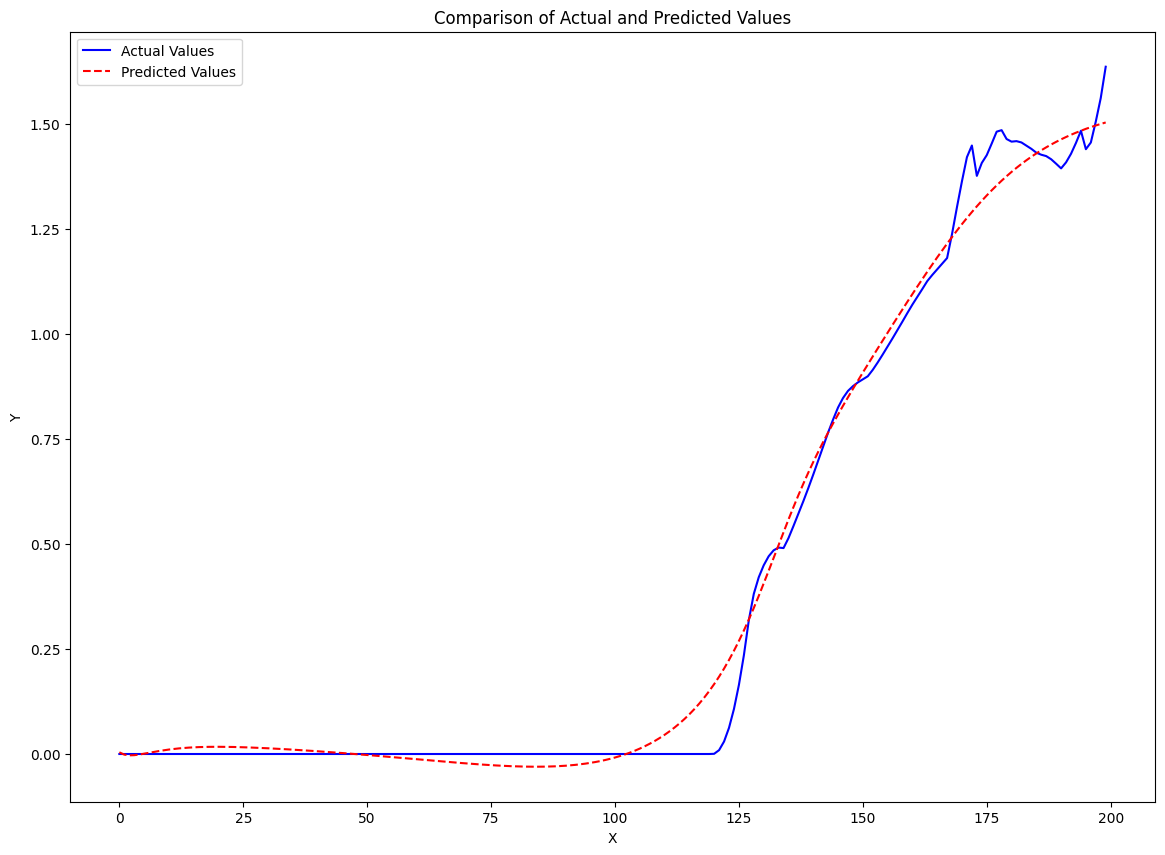

In [40]:
# Make predictions
predictions = model.predict(X_test_flat)

# Select a sample to visualize
actual = Y_test_combined[0]
predicted = predictions[0]
#print(Y_test_combined[0])
#print('1',predictions[0])
import matplotlib.pyplot as plt

# Plotting the actual vs. predicted values for the first feature
plt.figure(figsize=(14, 10))
plt.plot(actual[:, 0], label='Actual Values', color='blue')
plt.plot(predicted[:, 0], label='Predicted Values', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


#### R2 and RMSE of LSTM Model

In [43]:
# Flatten the arrays for metric calculations
actual_flat = Y_test_combined.reshape(-1, 2)
predicted_flat = predictions.reshape(-1, 2)

# Calculate RMSE for each feature, since Absorption is Stacked with Energy ( first is Absorption)
rmse_feature_0 = np.sqrt(mean_squared_error(actual_flat[:, 0], predicted_flat[:, 0]))
rmse_feature_1 = np.sqrt(mean_squared_error(actual_flat[:, 1], predicted_flat[:, 1]))

# Calculate R² for each feature
r2_feature_0 = r2_score(actual_flat[:, 0], predicted_flat[:, 0])
r2_feature_1 = r2_score(actual_flat[:, 1], predicted_flat[:, 1])

print(f'RMSE for Absorption: {rmse_feature_0}')
print(f'RMSE for Energy: {rmse_feature_1}')
print(f'R² for Absorption: {r2_feature_0}')
print(f'R² for Energy: {r2_feature_1}')


RMSE for Absorption: 0.04972953729807411
RMSE for Energy: 0.03288242645203609
R² for Absorption: 0.9914816195004958
R² for Energy: 0.9979094336487203


### New Section to trial Absorption prediction
extracting all Spectra data files onto combined_df and saving it on 'spectra_data.json'

In [ ]:
import os
import glob
import pandas as pd
import re

# List and sort spectra files numerically based on the digits in the filename
spectra_files = sorted(
    glob.glob(os.path.join(spectra_directory, "absorption_spectra_*.dat")),
    key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0])
)

# Initialize a list to store data for each spectra
spectra_list = []

# Load each absorption spectra into separate entries in the list
for spectra in spectra_files:
    # Read the data from the file
    spectra_data = pd.read_csv(spectra, sep='\\s+', header=None)
    # Separate the columns into two lists: one for energy and one for absorption coefficient
    energies = spectra_data[0].tolist()  # Assuming the first column is energy
    absorptions = spectra_data[1].tolist()  # Assuming the second column is absorption coefficient
    # Get the spectra index from the file name, assuming it ends with .dat and starts after the last underscore
    spectra_index = int(re.findall(r'\d+', os.path.basename(spectra))[0])
    # Add a dictionary for the current spectra to the list
    spectra_list.append({'Spectra': spectra_index, 'Energy': energies, 'Absorption': absorptions})

# Create DataFrame from list of dictionaries
combined_df = pd.DataFrame(spectra_list)

# Sort the DataFrame by 'Spectra' column to ensure it is in the correct order
combined_df.sort_values('Spectra', inplace=True)

# Convert DataFrame to JSON format
output_path = os.path.join(spectra_directory, "spectra_data.json")
combined_df.to_json(output_path, orient='records', indent=4)

# Print confirmation that the file has been saved
print(f"Spectra data saved to {output_path}")


In [ ]:
# List and sort spectra files numerically based on the digits in the filename
spectra_files = sorted(
    glob.glob(os.path.join(spectra_directory, "absorption_spectra_*.dat")),
    key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0])
)

#Loading bandgap to act as threshold cutoff to find urbach tail
bandgap = pd.read_csv(os.path.join(features_directory,'all_bandgap.csv'))

# Initialize a list to store data for each spectra
spectra_list = []

# Load each absorption spectra into separate entries in the list
for i, spectra in enumerate(spectra_files):
    # Read the data from the file
    spectra_data = pd.read_csv(spectra, sep='\\s+', header=None)
    # Separate the columns into two lists: one for energy and one for absorption coefficient
    energies = spectra_data[0].tolist()
    absorptions = spectra_data[1].tolist()
    
    # Get the bandgap value for the corresponding spectrum
    bg_value = bandgap.loc[i, 'Bandgap/eV']
    
    # Filter out energy values up to a few eV above Bandgap
    filtered_energies = [e for e in energies if e <= (bg_value + 0.5)]
    # Corresponding absorption values must also be filtered
    filtered_absorptions = [absorptions[j] for j, e in enumerate(energies) if e <= (bg_value + 0.5)]
    
    # Add a dictionary for the current spectra to the list
    spectra_list.append({
        'Spectra': int(re.findall(r'\d+', os.path.basename(spectra))[0]),
        'Energy': filtered_energies,
        'Absorption': filtered_absorptions
    })

# Create DataFrame from list of dictionaries
cutoff_spectra_df = pd.DataFrame(spectra_list)

#combining 'bandgap' DataFrame and filtered_spectra_df
cutoff_spectra_df['Bandgap'] = bandgap['Bandgap/eV']

# Define the path where you want to save the excel file
output_path = os.path.join(spectra_directory,'cutoff_spectra.csv')

# Save the combined DataFrame 
cutoff_spectra_df.to_csv(output_path,index=True)

print(cutoff_spectra_df.head(1))

#### Visualising Log(abs) against Energy Plot (Original Plot)

In [ ]:
# Load the dataset
cutoff_spectra_df = pd.read_csv(os.path.join(spectra_directory,'cutoff_spectra.csv'), index_col=0)

# User input for which spectrum to display
number = input("Which spectra would you like to see: ")
selected_spectrum = cutoff_spectra_df.iloc[int(number)]

# Use literal_eval to convert string representations into actual lists
energy_values = ast.literal_eval(selected_spectrum['Energy'])
absorption_values = ast.literal_eval(selected_spectrum['Absorption'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(energy_values, absorption_values, marker='o',markersize=2, linestyle='-', color='b')
plt.title(f'Absorption Spectrum {number}')
plt.xlabel('Energy (eV)')
plt.ylabel('Log Absorption Coefficient')
plt.yscale('log')
#Optional Zoom between x-range
plt.xlim(1.5, 2.2)
#Optional Zoom between y-range
#plt.ylim(0,4)

plt.grid(True)
plt.show()


#### Creating a Log(abs) column

In [ ]:
import ast

# Function to convert string to list, as Energy/Absorption columns are strings.
#Need to convert before manipulation
def string_to_list(i):
    return ast.literal_eval(i)

cutoff_spectra_df['Absorption'] = cutoff_spectra_df['Absorption'].apply(string_to_list)
cutoff_spectra_df['Energy'] = cutoff_spectra_df['Energy'].apply(string_to_list)

# logarithm function that ensures no -infinite when log(0)
def logging(arr):
    arr = np.array(arr) + 1e-9  # Adjust non-positive values
    return np.log(arr)

cutoff_spectra_df['log_absorption'] = cutoff_spectra_df['Absorption'].apply(logging)
spectra2 = cutoff_spectra_df 

##### Calculating Gradient

In [ ]:
energies = spectra2['Energy']
absorptions = spectra2['log_absorption']

#Padding length 100 points, can be adjusted
max_length = 100 
energy_padded = pad_sequences(energies, maxlen=max_length, dtype='float32', padding='post')
absorption_padded = pad_sequences(absorptions, maxlen=max_length, dtype='float32', padding='post')

# Prepare target array, Y
Y = np.stack((energy_padded, absorption_padded), axis=-1) 

energy_padded = np.array(energy_padded)
absorption_padded = np.array(absorption_padded)

gradient = np.zeros_like(absorption_padded)

# Compute the gradient for each spectrum
for i in range(energy_padded.shape[0]):
    gradient[i] = np.gradient(absorption_padded[i], energy_padded[i])

print(gradient[:1])

##### Visualizaing Gradient of Spectrum

In [ ]:
# Choosing which spectrum to check
index = 120

plt.figure(figsize=(10, 6))

# Plot log(Absorption Coefficient) vs Energy
plt.scatter(energy_padded[index], absorption_padded[index], label='log(Absorption Coefficient)', color='blue', s=10)

# Plotting the gradient
plt.scatter(energy_padded[index], gradient[index], label='First Derivative', color='red', s=10)

plt.xlabel('Energy (eV)')
plt.ylabel('Value')
plt.title(f'log(Absorption Coefficient) and its First Derivative (Spectrum {index})')
plt.legend()
plt.grid(True)
plt.show()

##### Calculating slope

In [ ]:
slope = np.zeros_like(absorption_padded)

# Compute the second derivatives for each spectrum
for i in range(energy_padded.shape[0]):
    slope[i] = np.gradient(gradient[i], energy_padded[i])

print(slope[:1])

##### Visualizing the slope of the spectrum

In [ ]:
index = 120

plt.figure(figsize=(10, 6))

# Plot log(Absorption Coefficient) vs Energy with smaller points
plt.scatter(energy_padded[index], absorption_padded[index], label='log(Absorption Coefficient)', color='blue', s=10)

# Plot the second derivative with smaller points
plt.scatter(energy_padded[index], slope[index], label='Second Derivative', color='green', s=10)

plt.xlabel('Energy (eV)')
plt.ylabel('Value')
plt.title(f'log(Absorption Coefficient), Second Derivatives (Spectrum {index})')
plt.legend()
plt.grid(True)
plt.show()

##### X/Y Train Test Split

In [ ]:
bandgap = np.array(spectra2['Bandgap'])
bandgap_repeated = np.repeat(bandgap[:, np.newaxis], energy_padded.shape[1], axis=1)

above_bandgap = (energy_padded > bandgap_repeated).astype(float)

#Stacking all features together for X
X = np.stack([gradient, slope, bandgap_repeated,above_bandgap], axis=-1)
#Y has been defined a few steps above

#Checking 638 rows, 100 step, 3 features
print(X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled,Y, test_size = 0.2, random_state = 100)

bandgap_train = bandgap_repeated[:X_train.shape[0], 0].reshape(-1, 1)
bandgap_test = bandgap_repeated[:X_test.shape[0], 0].reshape(-1, 1)

#### Define LSTM Model from tensorflow 

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ExpandTileLayer(Layer):
    def __init__(self, time_steps, **kwargs):
        super().__init__(**kwargs)
        self.time_steps = time_steps

    def call(self, bandgap_input):
        bandgap_expanded = tf.expand_dims(bandgap_input, axis=1)
        bandgap_tiled = tf.tile(bandgap_expanded, [1, self.time_steps, 1])
        return bandgap_tiled

    def get_config(self):
        config = super().get_config()
        config.update({"time_steps": self.time_steps})
        return config


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, Concatenate
from tensorflow.keras.models import Model

# Define the input shapes
input_shape = (X_train.shape[1], X_train.shape[2])

# Inputs
main_input = Input(shape=input_shape, name='main_input')
bandgap_input = Input(shape=(1,), name='bandgap_input')

# LSTM layers
x = LSTM(100, return_sequences=True)(main_input)
x = Dropout(0.2)(x)
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(100, return_sequences=True)(x)

# Expand and tile the bandgap input to match the time steps
bandgap_tiled = ExpandTileLayer(time_steps=input_shape[0])(bandgap_input)

# Concatenate bandgap input to every timestep
x = Concatenate()([x, bandgap_tiled])

# TimeDistributed layer
output = TimeDistributed(Dense(2))(x)

# Define the model
model = Model(inputs=[main_input, bandgap_input], outputs=output)

model.summary()

#### Creating custom loss function

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

# Define the custom loss function
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        self.mse = MeanSquaredError()

    def call(self, y_true, y_pred):
        # Extract energy and absorption values from y_true and y_pred
        energy_true = y_true[:, :, 0]
        absorption_true = y_true[:, :, 1]
        energy_pred = y_pred[:, :, 0]
        absorption_pred = y_pred[:, :, 1]

        # Extract bandgap from y_pred (last channel)
        bandgap = y_pred[:, :, -1]

        # Create a mask where energy values are above the bandgap
        mask = tf.cast(energy_true >= bandgap, tf.float32)

        # Calculate the MSE loss for energy and absorption, applying the mask
        energy_loss = self.mse(energy_true, energy_pred) * mask
        absorption_loss = self.mse(absorption_true, absorption_pred) * mask

        # Combine the losses
        total_loss = energy_loss + absorption_loss

        # Return the mean loss
        return tf.reduce_mean(total_loss)


In [ ]:
# Custom training step
@tf.function
def train_step(model, main_input, bandgap_input, targets, optimizer, loss_fn):
    with tf.GradientTape() as tape:
        predictions = model([main_input, bandgap_input], training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


##### Training the LSTM model

In [ ]:
import numpy as np
import tensorflow as tf

# Data
main_input_train = X_train
bandgap_input_train = bandgap_train
targets_train = Y_train

# Custom loss function instance
loss_fn = CustomLoss()

# Optimizer
optimizer = tf.keras.optimizers.Adam()

# Training
epochs = 100
batch_size = 32

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices(((main_input_train, bandgap_input_train), targets_train))
dataset = dataset.batch(batch_size)

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    for step, ((batch_main_input, batch_bandgap_input), batch_targets) in enumerate(dataset):
        loss = train_step(model, batch_main_input, batch_bandgap_input, batch_targets, optimizer, loss_fn)
        print(f'Step {step + 1}, Loss: {loss.numpy()}')

# Evaluation
main_input_test = X_test
bandgap_input_test = bandgap_test
test_loss = loss_fn(Y_test, model([main_input_test, bandgap_input_test]))
print(f'Test Loss: {test_loss.numpy()}')

# Prediction
Y_pred = model([main_input_test, bandgap_input_test])


In [ ]:
import matplotlib.pyplot as plt

# Choose the number of examples to visualize
n_examples = 3

# Plot the energy against absorption for a few examples
fig, axes = plt.subplots(n_examples, 1, figsize=(10, 15))

for i in range(n_examples):
    # Plot the true energy vs absorption values
    axes[i].plot(Y_test[i, :, 0], Y_test[i, :, 1], label='True', color='blue', marker='o')
    # Plot the predicted energy vs absorption values
    axes[i].plot(Y_pred[i, :, 0], Y_pred[i, :, 1], label='Predicted', color='red', linestyle='--')
    axes[i].set_xlabel('Energy (eV)')
    axes[i].set_ylabel('Absorption')
    axes[i].legend()
    axes[i].set_title(f'Sample {i+1} - Energy vs Absorption')

plt.tight_layout()
plt.show()
